In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

In [2]:
def test_stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(ts, lags=30):
    test_stationarity(ts)
    if not isinstance(ts, pd.Series):
        ts = pd.Series(ts)
    with plt.style.context('bmh'):
        plt.figure(figsize=(16,8))
        ts_ax = plt.subplot2grid((5, 1), (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid((5, 1), (2, 0))
        pacf_ax = plt.subplot2grid((5, 1), (3, 0))
        qq_ax = plt.subplot2grid((5, 1), (4, 0))

        ts.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(ts, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(ts, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(ts, line='s', ax=qq_ax)

        plt.tight_layout()

**В качестве временного ряда возьму график ежедневных изменений индекса биржи Dow-Jones за последние 3 года**

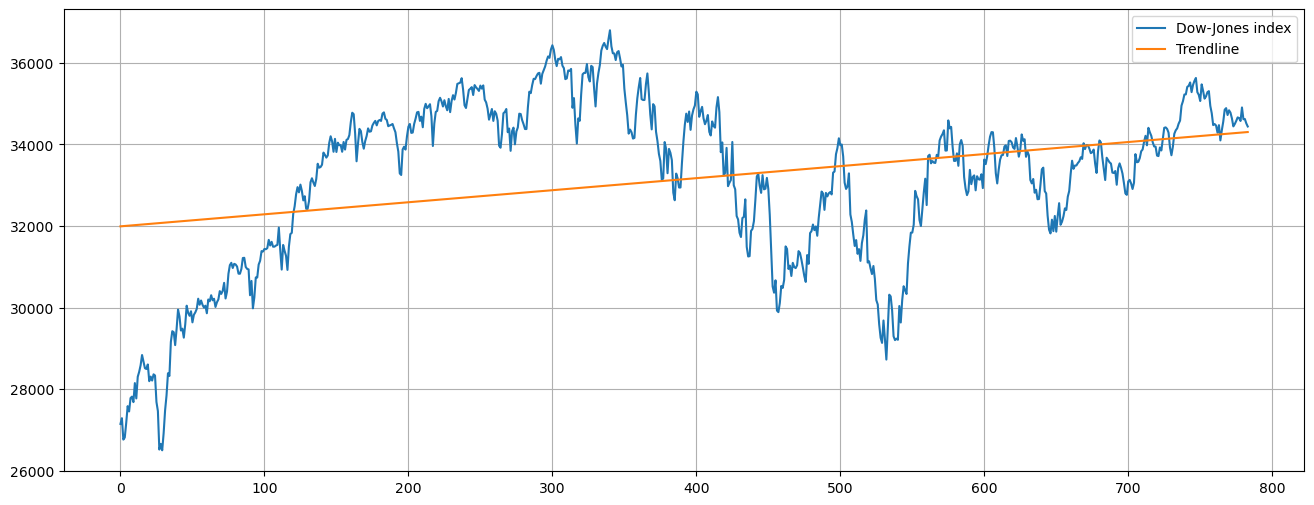

In [4]:
series = np.flip(pd.read_csv('dow-jones.csv').dowjones.values)

x_axis = range(len(series))
z = np.polyfit(x_axis, series, 1)
p = np.poly1d(z)

plt.figure(figsize=(16,6))
plt.plot(series, label='Dow-Jones index')
plt.plot(x_axis, p(x_axis), label='Trendline')
plt.legend()
plt.grid();

**В данных есть восходящий тренд. Избавлюсь от него, продифференцировав исходный ряд, и проверю получившийся ряд на стационарность**

Results of Dickey-Fuller Test:
Test Statistic                 -27.661693
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    782.000000
Critical Value (1%)             -3.438740
Critical Value (5%)             -2.865243
Critical Value (10%)            -2.568742
dtype: float64


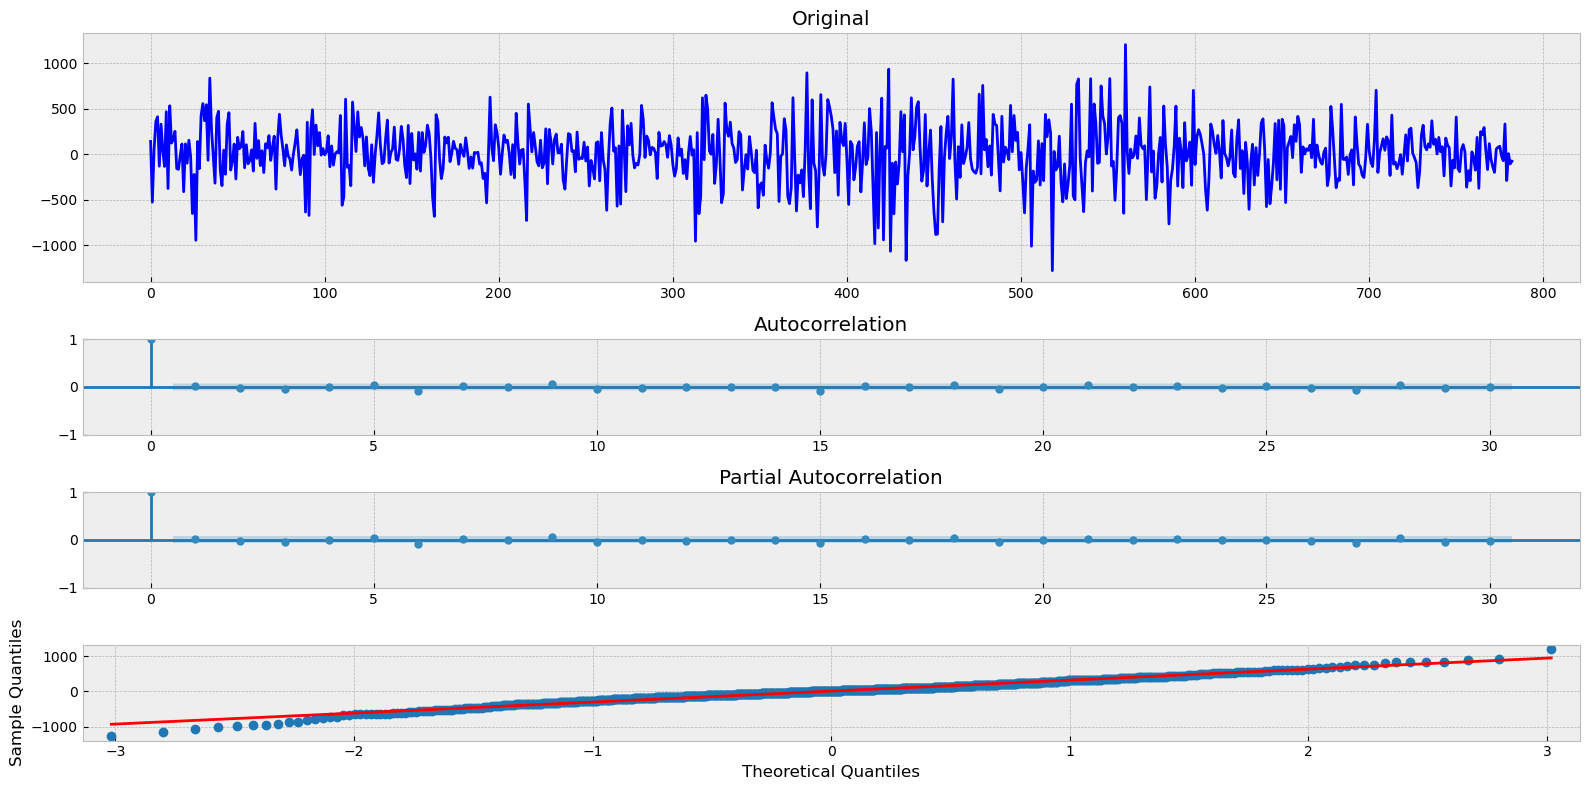

In [5]:
series_diff = series[1:] - series[:-1]
tsplot(series_diff)

**Получившийся ряд стационарен. Теперь в цикле подберу гиперпараметры `p d q` для модели ARIMA**

In [6]:
from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf
best_order = None
best_model = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                model = ARIMA(series_diff, order=(i, d, j), trend='n').fit()
                if model.aic < best_aic:
                    best_model, best_aic, best_order = model, model.aic, (i, d, j)
                if best_model == model:
                    print('best aic:', best_aic, 'best order:', best_order)
            except:
                continue

best aic: 11223.522869308876 best order: (0, 0, 0)
best aic: 11218.076832152074 best order: (0, 1, 1)
best aic: 11215.13847273455 best order: (2, 1, 3)


Results of Dickey-Fuller Test:
Test Statistic                 -27.353019
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    782.000000
Critical Value (1%)             -3.438740
Critical Value (5%)             -2.865243
Critical Value (10%)            -2.568742
dtype: float64


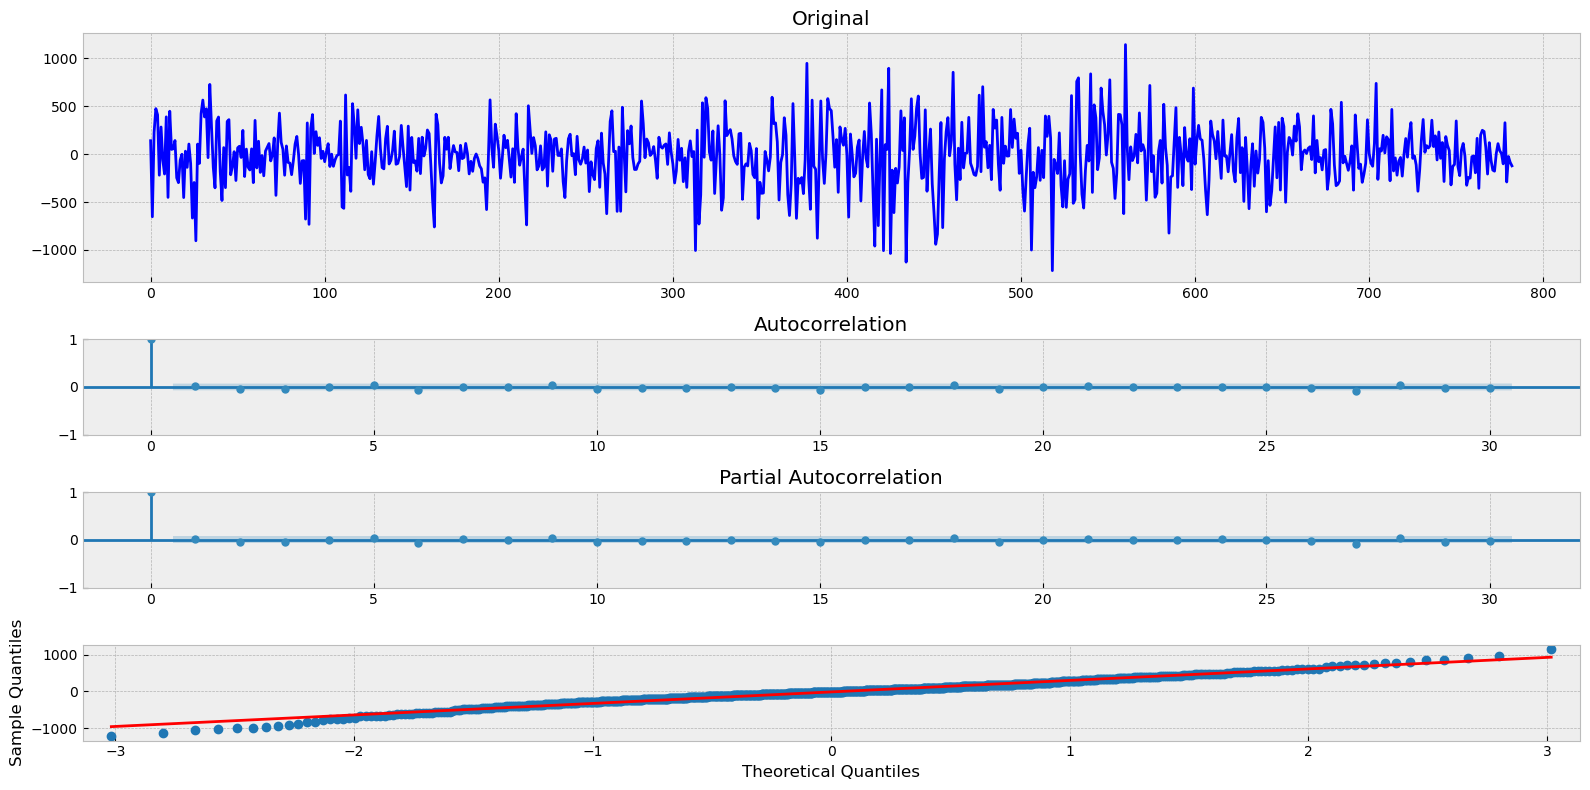

In [7]:
tsplot(best_model.resid)

**Посмотрев на графики остатков можно предположить, что модели удалось подобрать оптимальные гиперпараметры. Ряд выглядит похожим на белый шум. Теперь подобранные моделью ARIMA значения гиперпараметров подставлю в модель GARCH**

In [8]:
from arch import arch_model

p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

am = arch_model(series_diff, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     56,   Neg. LLF: 5554.156186473199
Iteration:     10,   Func. Count:    106,   Neg. LLF: 5554.146539768311
Iteration:     15,   Func. Count:    156,   Neg. LLF: 5554.146457725865
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5554.146453384057
            Iterations: 17
            Function evaluations: 176
            Gradient evaluations: 17
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5554.15
Distribution:      Standardized Student's t   AIC:                           11126.3
Method:                  Maximum Likelihood   BIC:                           11168.3
                                              No. Observations: 

Results of Dickey-Fuller Test:
Test Statistic                 -27.661693
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    782.000000
Critical Value (1%)             -3.438740
Critical Value (5%)             -2.865243
Critical Value (10%)            -2.568742
dtype: float64


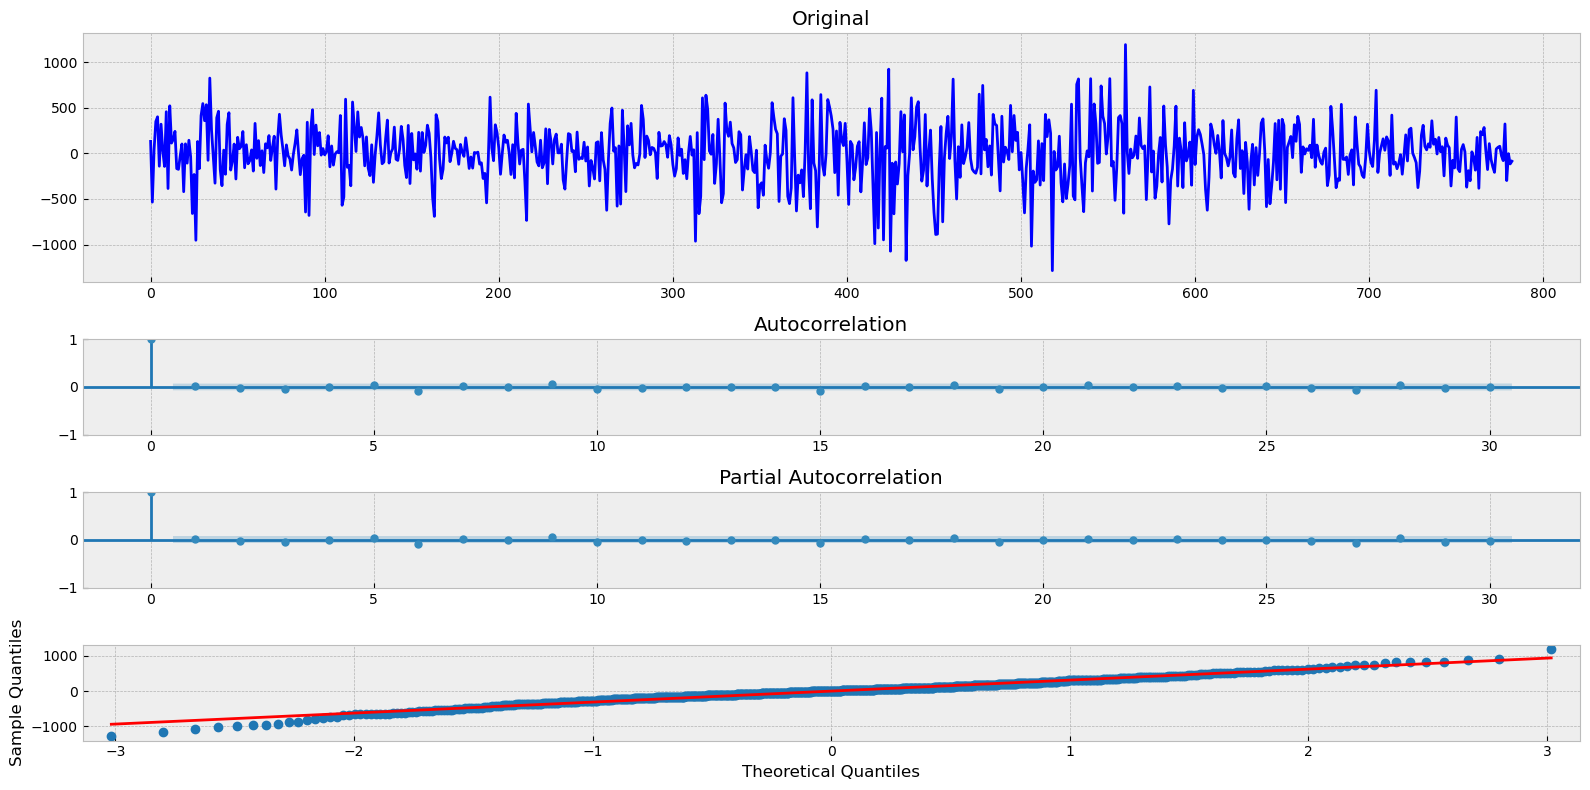

In [9]:
tsplot(res.resid)

**Опять же можно видеть, что график остатков выглядит, как белый шум. Графики автокорреляции свидетельствуют о том же. Можно предположить, что модели удалось подобрать коэффициенты, которые неплохо объясняют рассматриваемый временной ряд. Но интересно сравнить получившиеся остатки на одном графике вместе с исходным временным рядом. Для этого с остатками я проделаю операцию обратную дифференцированию временного ряда с помощью функции `numpy.cumsum`**

In [10]:
garch_resid = np.r_[series[0], res.resid].cumsum()

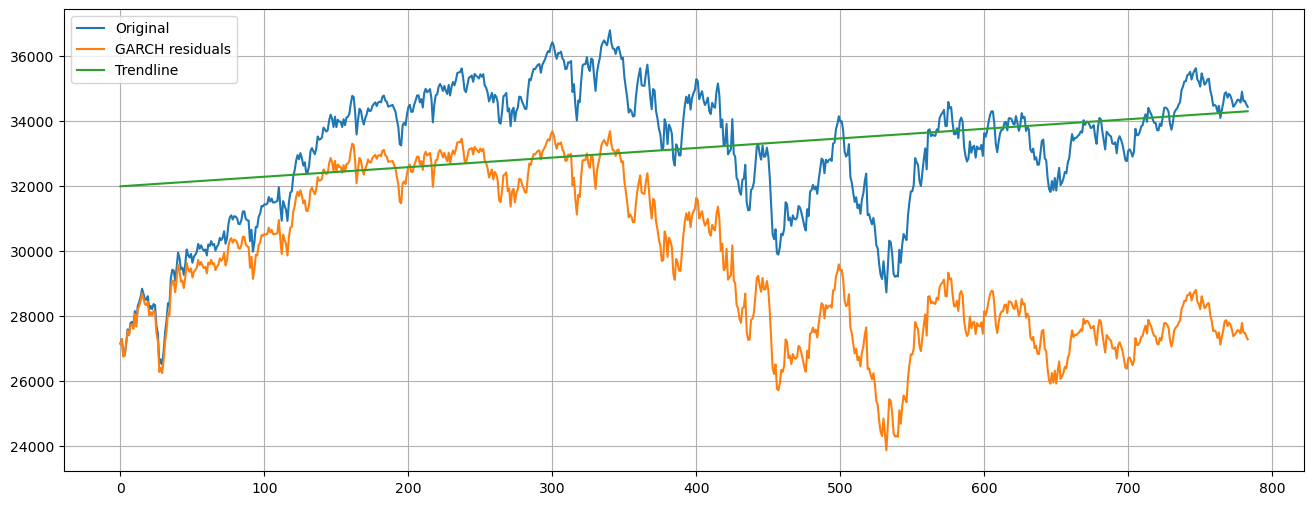

In [11]:
plt.figure(figsize=(16,6))
plt.plot(series, label='Original')
plt.plot(garch_resid, label='GARCH residuals')
plt.plot(x_axis, p(x_axis), label='Trendline')
plt.legend()
plt.grid();

**Проинтегрированный график остатков практически полностью повторяет каждое колебание исходного временного ряда, отличие лишь в их уровнях. Кажется, что стоит лишь добавить дополнительную компоненту тренда в остатки и будет полное совпадение. На мой взгляд это означает, что остатки включают в себя почти всю информацию из исходного ряда, кроме восходящего тренда. Получается, что модель только лишь и смогла вытащить из данных этот тренд, а вся остальная информация пошла в остатки. Из этого следует, что спрогнозировать колебания котировок биржи Dow-Jones такой моделью будет невозможно, однозначно можно лишь утверждать о наличии тренда, но это было понятно и без модели.**